# Transitions NREM-REM

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

# Utils Functions

In [3]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

In [4]:
def transition(states, template,epsilon = 0):
    '''
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any transition in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    '''
    if epsilon is list:
        print('eplist')
    long = pd.DataFrame()
    for s,i in states.items():
        i['state'] = s
        long = pd.concat((i,long))
        del i['state']
    order = np.argsort(long.start)
    long = long.iloc[order]
    
    transition_times = []
    transition_intervals = []
    for i,s in enumerate(long.state):
        tmp = list(long.state[i:i+len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i:i+len(template)]
#             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start)/1_000_000
            if np.any(length.values<epsilon): 
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre,tmp_post],0)
            
            
            transition_intervals.append([tmp_transition.start.iloc[0],tmp_transition.end.iloc[-1]])
            transition_times.append(tmp_times)
    
    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(start = transition_intervals[:,0],end = transition_intervals[:,1],force_no_fix = True)
    return transition_intervals,transition_times

## Computing

In [5]:
def sanity_check(neurons,states,intervals,timing):
#     plt.ioff()
    f = plt.figure(figsize=(12,4),dpi = 300)
    ax = plt.subplot(3,1,1)
    plt.suptitle(f'Rat : {bk.load.rat} Day : {bk.load.day} - {bk.load.session}')
    
    for k,s in states.items():
        if   k == 'Rem'    : c = 'orange'
        elif k == 'sws'    : c = 'grey'
        elif k == 'wake'   : c = 'pink'
        elif k == 'drowsy' : c = 'green'
            
        bk.plot.intervals(s,c)

    
    plt.subplot(3,1,2,sharex = ax)
    bk.plot.intervals(intervals)
    for i in timing.ravel(): plt.axvline(i/1_000_000)

    plt.subplot(3,1,3,sharex = ax)
    bk.plot.rasterPlot(neurons)
    plt.tight_layout()
    
#     plt.savefig(f'/home/billel/figs/{bk.load.session}.jpeg')
#     f.clear()
#     plt.close(f)
#     lfp = bk.load.loadLFP()
#     plt.subplot(4,1,4,sharex = ax)
#     plt.plot(lfp.as_units('s'))
    

In [6]:
def compute_transition_activity_not_normalized(neurons,timing,before,after):
    timing = timing / 1_000_000
    transition_activity = []
    spec = []
    for t in timing: #For each transitions
        chan = bk.load.random_channel('BLA')
        start = t-before
        stop = t+after
        _,b = bk.compute.binSpikes(neurons,binSize = 1,start=start,stop = stop)
        transition_activity.append(b)
        lfp = bk.load.lfp(chan,start,stop)
        
        f,t,Sxx = scipy.signal.spectrogram(lfp.values,1250,nperseg=5000,noverlap=2500)
        spec.append(Sxx)
    plt.figure(figsize=[12,4])
    plt.pcolormesh(t, f, np.log(np.mean(spec,0)), shading='gouraud')
    plt.clim([8,10])
    plt.ylim([0,20])
    plt.xlim(0,120)
    plt.title('BLA')
        
    
#     print((np.array(spec).shape))
    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity,0,2)
    
    transition_spec = np.array(spec)
    transition_spec = np.moveaxis(transition_spec,0,2)

    return transition_activity,[f,t,transition_spec]

def main_non_normalized(local_path = 'Rat08/Rat08-20130713',arg = None,plot = True, save = False):
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    transition_name = ['sws','Rem']

    print(f'Computing {transition_name} transitions')
    intervals,timing = transition(states,transition_name,epsilon=[90,30]) #Find the timing of the transitions
    print(f'Found {len(intervals)} transitions')

    transition_activity,(f,t,transition_spec) = compute_transition_activity_not_normalized(neurons,timing,90,31)

    if plot:
#         y_bla_pyr = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Pyr')],2).T,0),1)
#         y_bla_int = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Int')],2).T,0),1)
        bla_std   = scipy.stats.sem(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Pyr')],2).T,1)
        y_bla_pyr = np.mean(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Pyr')],2).T,1)
#         y_hpc = np.mean(scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0),1)

        plt.figure(figsize=[12,4])
#         plt.plot(y_bla_int,'k--')
        plt.plot(y_bla_pyr,'green')
        plt.plot(y_bla_pyr+bla_std,'g--',y_bla_pyr-bla_std,'g--')
        plt.xlim(0,120)
        plt.axvspan(89,119,color = 'orange',alpha = 0.5)
#         plt.plot(y_hpc,'blue')

        plt.title(f'Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}')
        plt.show()

    return transition_activity,(f,t,transition_spec),metadata

In [ ]:
def compute_transition_activity(neurons,intervals,timing,bin_epochs,n_event):
    
    transition_activity = []
    for event,t in zip(intervals.iloc,timing): #For each transitions
        if n_event == 2: epochs = np.array([(event.start,t[0]),(t[0],event.end)],dtype = np.int64)
        if n_event == 3 :epochs = np.array([[event.start,t[0]],[t[0],t[1]],[t[1],event.end]])
        epochs = nts.IntervalSet(start = epochs[:,0],end = epochs[:,1])
        #Creates intervals for each state of the transitions events.


#         binned = np.array(shape = (252,np.sum(bin_epochs)))
#         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
        binned = np.empty(shape = (len(neurons),1))
        for i,epoch in enumerate(epochs.as_units('s').iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            _,b = bk.compute.binSpikes(neurons,start = start,stop = end,nbins=nbins)
            b = b/((end-start)/nbins) # Converting to firing rates
            binned = np.hstack((binned,b))
        binned = binned[:,1:]
        transition_activity.append(binned)

    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity,0,2)
    
    return transition_activity

def main(local_path = 'Rat08/Rat08-20130713',arg = None,plot = False, save = False):
    #Variables :
    if arg == None:
        transition_interest = [['Rem','sws','Rem']] #Template of transitions to follow.
        bin_epochs = [12,30,12]
        n_event = 3
    else:
        transition_interest = [arg[0]]
        bin_epochs = arg[1]
        n_event = arg[2]
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    for i,transition_name in enumerate(transition_interest): #For each kind of transitions
        print(f'Computing {transition_name} transitions')
        intervals,timing = transition(states,transition_name,epsilon=50) #Find the timing of the transitions
        print(f'Found {len(intervals)} transitions')
        
        transition_activity = compute_transition_activity(neurons,intervals,timing,bin_epochs,n_event)

        if plot:
            print(np.mean(transition_activity[metadata.Region == "BLA"],2).T.shape)
            y_bla = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "BLA"],2).T,0)
            y_hpc = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0)

            plt.figure()
            plt.plot(y_bla,'green')
            plt.plot(y_hpc,'blue')

            plt.title(f'Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}')
        print(os.getcwd())
        # sanity_check(neurons,states,intervals,timing)
        return np.array(transition_activity),metadata

In [242]:
def NREM_Control(local_path = 'Rat08/Rat08-20130713',arg = None ,plot = False, save = False):
    
    NREM_length = 250
    REM_length = 80*1_000_000
    bin_epochs = [30,12,30]
    
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    
    intervals,_ = transition(states,['sws'],NREM_length)
    m = (intervals.start+intervals.end)/2 
    timing = np.array([m-(REM_length/2),m+(REM_length/2)]).T
    print(f'Found {len(intervals)} transitions')
    
    transition_activity = compute_transition_activity(neurons,intervals,timing,bin_epochs)
#     sanity_check(neurons,states,intervals,timing)
    
    return np.array(transition_activity),metadata

In [8]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [258]:
arg = [['sws','Rem'],[30,12],2]
NREM_REM = bk.load.batch(main,arg,verbose=False,linux=True)

100%|██████████| 61/61 [01:38<00:00,  1.61s/it]

Batch finished in 98.18324494361877
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722']
3.278688524590164 %


In [9]:
arg = [['sws','Rem','sws'],[30,12,30],3]
NREM_REM_NREM = bk.load.batch(main,arg,verbose=False,linux=True)
arg = [['Rem','sws','Rem'],[12,30,12],3]
REM_NREM_REM = bk.load.batch(main,arg,verbose=False,linux=True)
arg = None
NREM_Control = bk.load.batch(NREM_Control,arg,verbose=False,linux=True)

100%|██████████| 61/61 [04:01<00:00,  3.96s/it]

Batch finished in 241.37935042381287
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


  0%|          | 0/61 [00:00<?, ?it/s]

Loading Data from Rat08-20130708
Rat : 8 on day : 1
Working with session Rat08-20130708 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy
Rat08-20130708-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 15 transitions
(15, 2501, 59)


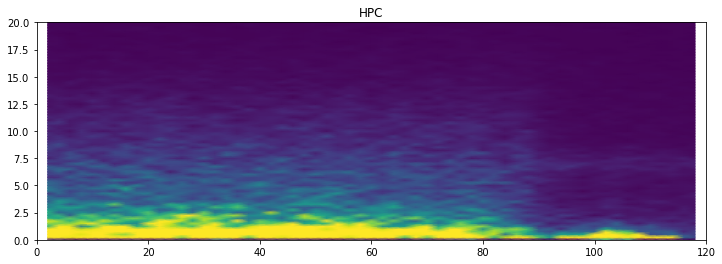

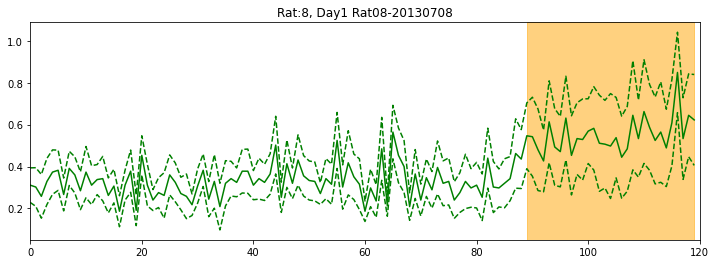

  2%|▏         | 1/61 [00:10<10:43, 10.73s/it]

Loading Data from Rat08-20130709
Rat : 8 on day : 2
Working with session Rat08-20130709 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
Rat08-20130709-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 13 transitions
(13, 2501, 59)


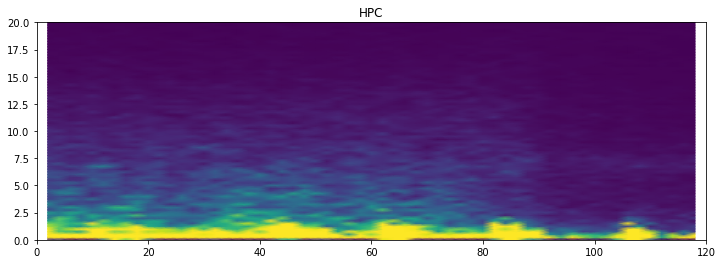

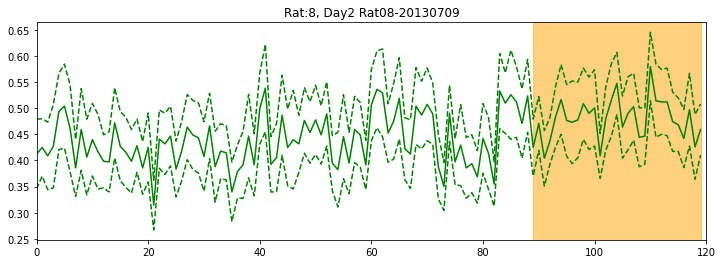

  3%|▎         | 2/61 [00:21<10:46, 10.96s/it]

Loading Data from Rat08-20130710
Rat : 8 on day : 3
Working with session Rat08-20130710 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130710
Data already saved in Numpy format, loading them from here:
Rat08-20130710-neurons.npy
Rat08-20130710-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 13 transitions
(13, 2501, 59)


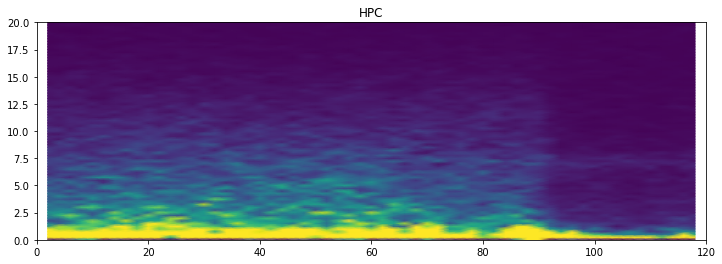

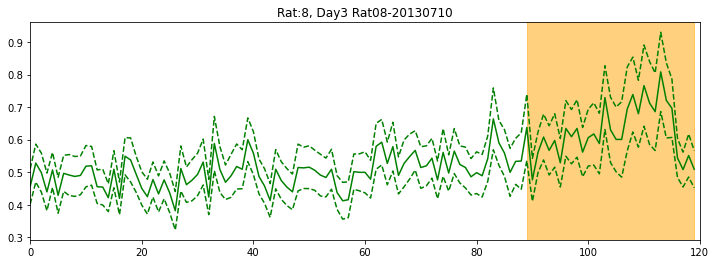

  5%|▍         | 3/61 [00:32<10:19, 10.68s/it]

Loading Data from Rat08-20130711
Rat : 8 on day : 4
Working with session Rat08-20130711 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130711
Data already saved in Numpy format, loading them from here:
Rat08-20130711-neurons.npy
Rat08-20130711-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 10 transitions
(10, 2501, 59)


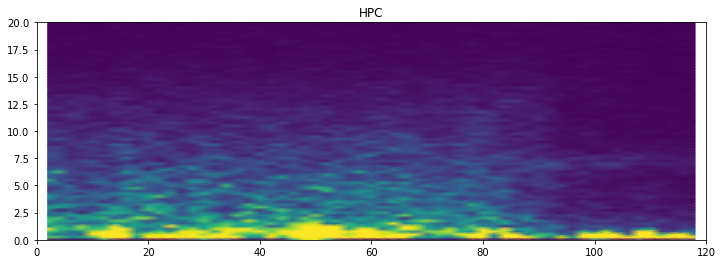

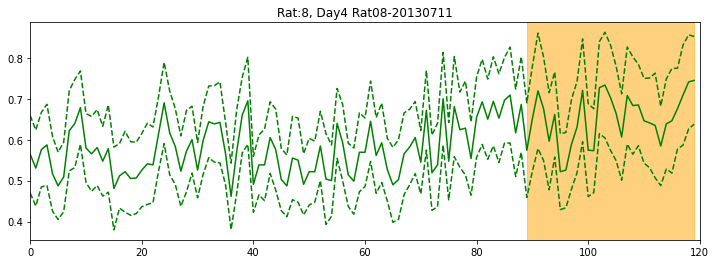

  7%|▋         | 4/61 [00:41<09:47, 10.30s/it]

Loading Data from Rat08-20130712
Rat : 8 on day : 5
Working with session Rat08-20130712 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130712
Data already saved in Numpy format, loading them from here:
Rat08-20130712-neurons.npy
Rat08-20130712-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 6 transitions
(6, 2501, 59)


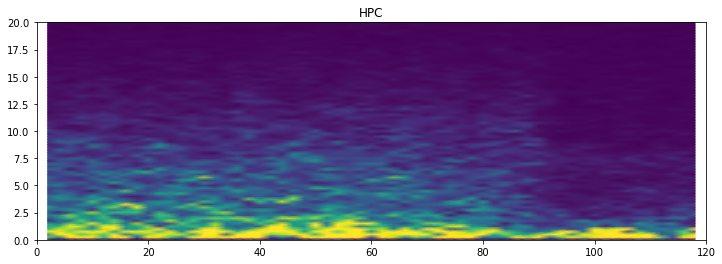

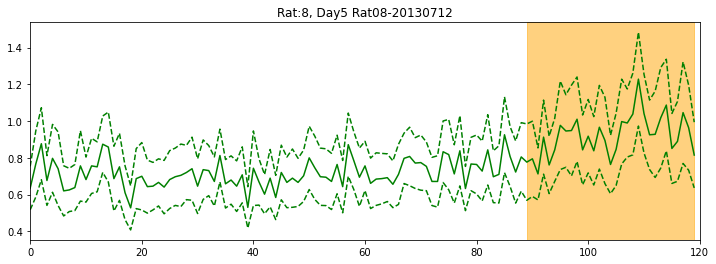

  8%|▊         | 5/61 [00:47<08:02,  8.62s/it]

Loading Data from Rat08-20130713
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 21 transitions
(21, 2501, 59)


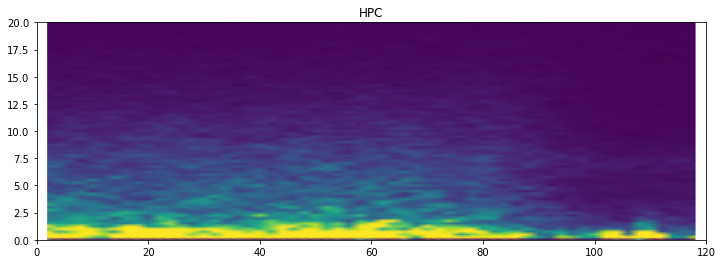

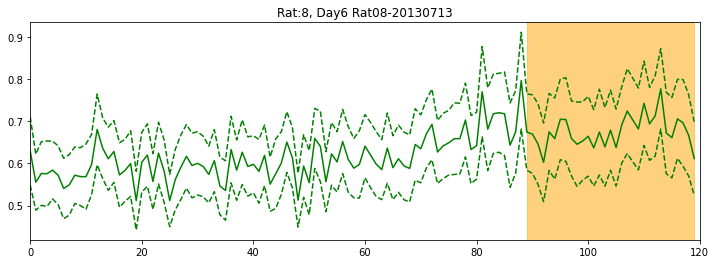

 10%|▉         | 6/61 [01:02<09:55, 10.82s/it]

Loading Data from Rat08-20130715
Rat : 8 on day : 7
Working with session Rat08-20130715 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130715
Data already saved in Numpy format, loading them from here:
Rat08-20130715-neurons.npy
Rat08-20130715-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 7 transitions
(7, 2501, 59)


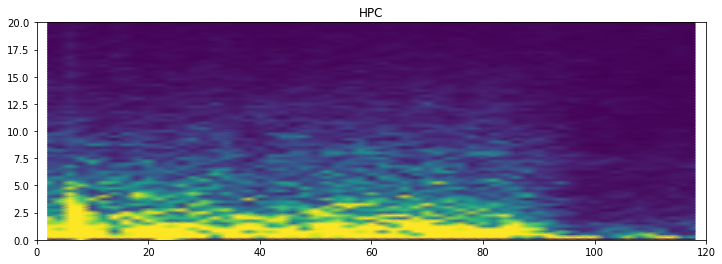

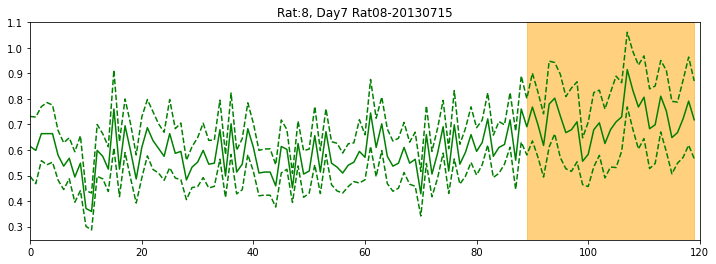

 11%|█▏        | 7/61 [01:08<08:14,  9.16s/it]

Loading Data from Rat08-20130716
Rat : 8 on day : 8
Working with session Rat08-20130716 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130716
Data already saved in Numpy format, loading them from here:
Rat08-20130716-neurons.npy
Rat08-20130716-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 7 transitions
(7, 2501, 59)


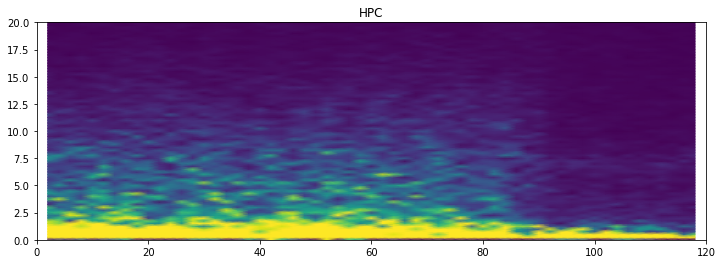

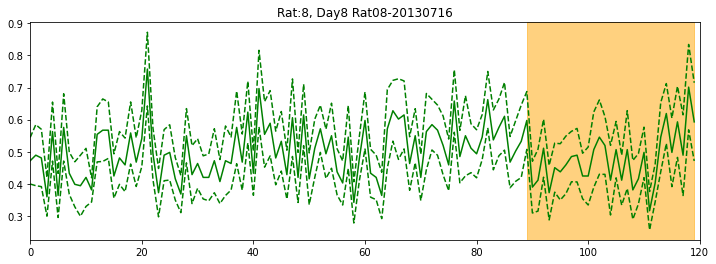

 13%|█▎        | 8/61 [01:14<07:06,  8.05s/it]

Loading Data from Rat08-20130717
Rat : 8 on day : 9
Working with session Rat08-20130717 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130717
Data already saved in Numpy format, loading them from here:
Rat08-20130717-neurons.npy
Rat08-20130717-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 13 transitions
(13, 2501, 59)


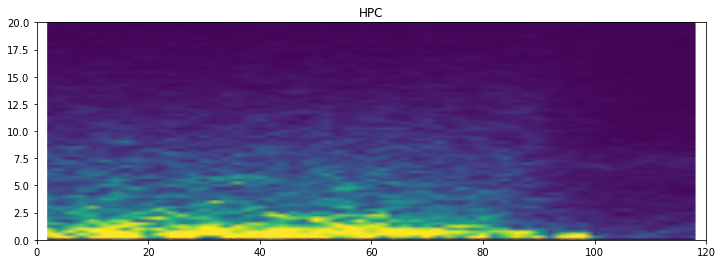

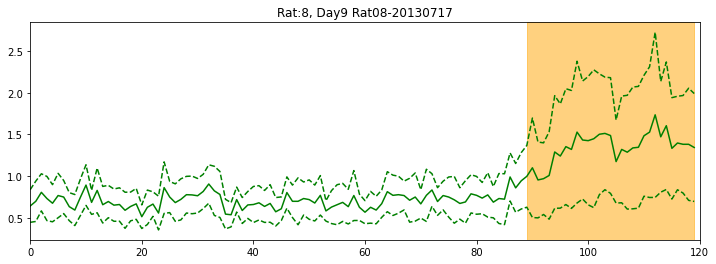

 15%|█▍        | 9/61 [01:23<07:23,  8.52s/it]

Loading Data from Rat08-20130718
Rat : 8 on day : 10
Working with session Rat08-20130718 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130718
Data already saved in Numpy format, loading them from here:
Rat08-20130718-neurons.npy


 16%|█▋        | 10/61 [01:24<05:16,  6.21s/it]

Rat08-20130718-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 6 transitions
Error in session Rat08-20130718
Loading Data from Rat08-20130719
Rat : 8 on day : 11
Working with session Rat08-20130719 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130719
Data already saved in Numpy format, loading them from here:
Rat08-20130719-neurons.npy


 18%|█▊        | 11/61 [01:25<03:45,  4.51s/it]

Rat08-20130719-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 9 transitions
Error in session Rat08-20130719
Loading Data from Rat08-20130720
Rat : 8 on day : 12
Working with session Rat08-20130720 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130720
Data already saved in Numpy format, loading them from here:
Rat08-20130720-neurons.npy


 20%|█▉        | 12/61 [01:26<02:46,  3.41s/it]

Rat08-20130720-metadata.npy
Error in session Rat08-20130720
Loading Data from Rat08-20130722
Rat : 8 on day : 13
Working with session Rat08-20130722 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130722
Data already saved in Numpy format, loading them from here:
Rat08-20130722-neurons.npy


 21%|██▏       | 13/61 [01:26<02:02,  2.56s/it]

Rat08-20130722-metadata.npy
Error in session Rat08-20130722
Loading Data from Rat09-20140324
Rat : 9 on day : 1
Working with session Rat09-20140324 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140324
Data already saved in Numpy format, loading them from here:
Rat09-20140324-neurons.npy
Rat09-20140324-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 11 transitions
(11, 2501, 59)


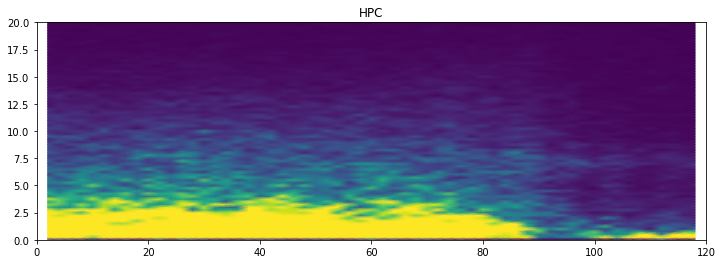

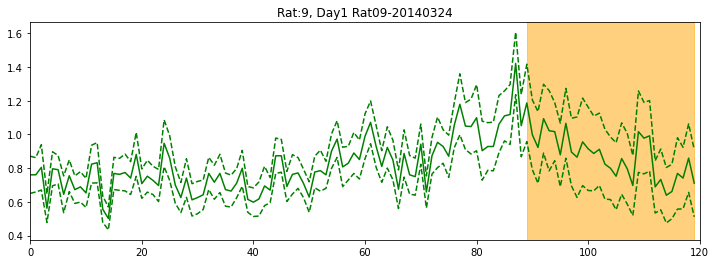

 23%|██▎       | 14/61 [01:35<03:28,  4.44s/it]

Loading Data from Rat09-20140325
Rat : 9 on day : 2
Working with session Rat09-20140325 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140325
Data already saved in Numpy format, loading them from here:
Rat09-20140325-neurons.npy
Rat09-20140325-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 7 transitions
(7, 2501, 59)


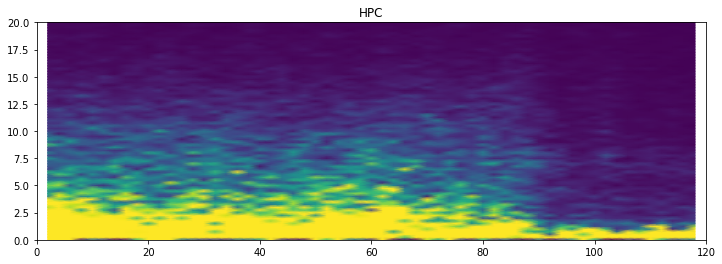

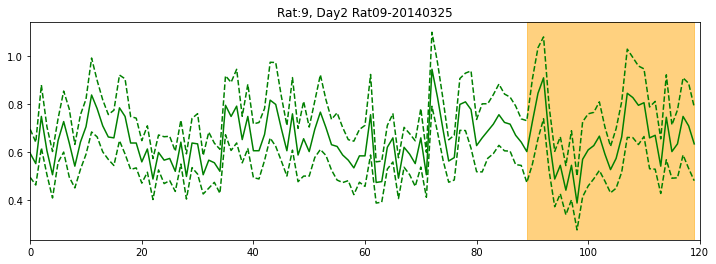

 25%|██▍       | 15/61 [01:42<03:53,  5.08s/it]

Loading Data from Rat09-20140326
Rat : 9 on day : 3
Working with session Rat09-20140326 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140326
Data already saved in Numpy format, loading them from here:
Rat09-20140326-neurons.npy
Rat09-20140326-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 9 transitions


 28%|██▊       | 17/61 [01:47<02:40,  3.66s/it]

Error in session Rat09-20140326
Loading Data from Rat09-20140327
Rat : 9 on day : 4
Working with session Rat09-20140327 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140327
Data already saved in Numpy format, loading them from here:
Rat09-20140327-neurons.npy
Error in session Rat09-20140327
Loading Data from Rat09-20140328
Rat : 9 on day : 5
Working with session Rat09-20140328 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140328
Data already saved in Numpy format, loading them from here:
Rat09-20140328-neurons.npy
Error in session Rat09-20140328
Loading Data from Rat09-20140329
Rat : 9 on day : 6
Working with session Rat09-20140329 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140329
Data already saved in Numpy format, loading them from here:
Rat09-20140329-neurons.npy


 31%|███       | 19/61 [01:47<01:25,  2.05s/it]

Error in session Rat09-20140329
Loading Data from Rat09-20140331
Rat : 9 on day : 7
Working with session Rat09-20140331 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140331
Data already saved in Numpy format, loading them from here:
Rat09-20140331-neurons.npy


 33%|███▎      | 20/61 [01:48<01:07,  1.64s/it]

Error in session Rat09-20140331
Loading Data from Rat09-20140401
Error in session Rat09-20140401
Loading Data from Rat09-20140402
Rat : 9 on day : 9
Working with session Rat09-20140402 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140402
Data already saved in Numpy format, loading them from here:
Rat09-20140402-neurons.npy


 38%|███▊      | 23/61 [01:48<00:31,  1.20it/s]

Error in session Rat09-20140402
Loading Data from Rat09-20140403
Rat : 9 on day : 10
Working with session Rat09-20140403 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140403
Data already saved in Numpy format, loading them from here:
Rat09-20140403-neurons.npy
Error in session Rat09-20140403
Loading Data from Rat09-20140404
Rat : 9 on day : 11
Working with session Rat09-20140404 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140404
Data already saved in Numpy format, loading them from here:
Rat09-20140404-neurons.npy


 39%|███▉      | 24/61 [01:49<00:26,  1.40it/s]

Error in session Rat09-20140404
Loading Data from Rat09-20140405
Rat : 9 on day : 12
Working with session Rat09-20140405 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140405
Data already saved in Numpy format, loading them from here:
Rat09-20140405-neurons.npy


 41%|████      | 25/61 [01:49<00:23,  1.56it/s]

Error in session Rat09-20140405
Loading Data from Rat09-20140407
Error in session Rat09-20140407
Loading Data from Rat09-20140408
Rat : 9 on day : 14
Working with session Rat09-20140408 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140408
Data already saved in Numpy format, loading them from here:
Rat09-20140408-neurons.npy


 44%|████▍     | 27/61 [01:50<00:17,  1.92it/s]

Rat09-20140408-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 4 transitions
Error in session Rat09-20140408
Loading Data from Rat09-20140409
Rat : 9 on day : 15
Working with session Rat09-20140409 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140409
Data already saved in Numpy format, loading them from here:
Rat09-20140409-neurons.npy


 46%|████▌     | 28/61 [01:50<00:16,  2.06it/s]

Rat09-20140409-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 6 transitions
Error in session Rat09-20140409
Loading Data from Rat10-20140619
Rat : 10 on day : 1
Working with session Rat10-20140619 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140619
Data already saved in Numpy format, loading them from here:
Rat10-20140619-neurons.npy
Rat10-20140619-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 8 transitions


 48%|████▊     | 29/61 [01:56<01:00,  1.90s/it]

Error in session Rat10-20140619
Loading Data from Rat10-20140620
Rat : 10 on day : 2
Working with session Rat10-20140620 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140620
Data already saved in Numpy format, loading them from here:
Rat10-20140620-neurons.npy


 51%|█████     | 31/61 [01:57<00:32,  1.09s/it]

Error in session Rat10-20140620
Loading Data from Rat10-20140622
Rat : 10 on day : 3
Working with session Rat10-20140622 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140622
Data already saved in Numpy format, loading them from here:
Rat10-20140622-neurons.npy
Error in session Rat10-20140622
Loading Data from Rat10-20140624
Rat : 10 on day : 4
Working with session Rat10-20140624 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140624
Data already saved in Numpy format, loading them from here:
Rat10-20140624-neurons.npy
Error in session Rat10-20140624
Loading Data from Rat10-20140626
Rat : 10 on day : 5
Working with session Rat10-20140626 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140626
Data already saved in Numpy format, loading them from here:
Rat10-20140626-neurons.npy


 54%|█████▍    | 33/61 [01:57<00:19,  1.46it/s]

Error in session Rat10-20140626
Loading Data from Rat10-20140627
Error in session Rat10-20140627
Loading Data from Rat10-20140628
Rat : 10 on day : 7
Working with session Rat10-20140628 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140628
Data already saved in Numpy format, loading them from here:
Rat10-20140628-neurons.npy


 57%|█████▋    | 35/61 [01:57<00:12,  2.14it/s]

Error in session Rat10-20140628
Loading Data from Rat10-20140629
Rat : 10 on day : 8
Working with session Rat10-20140629 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140629
Error in session Rat10-20140629
Loading Data from Rat10-20140701
Rat : 10 on day : 9
Working with session Rat10-20140701 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140701
Data already saved in Numpy format, loading them from here:
Rat10-20140701-neurons.npy


 61%|██████    | 37/61 [01:58<00:08,  2.68it/s]

Error in session Rat10-20140701
Loading Data from Rat10-20140702
Rat : 10 on day : 10
Working with session Rat10-20140702 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140702
Data already saved in Numpy format, loading them from here:
Rat10-20140702-neurons.npy


 64%|██████▍   | 39/61 [01:58<00:06,  3.48it/s]

Error in session Rat10-20140702
Loading Data from Rat10-20140703
Rat : 10 on day : 11
Working with session Rat10-20140703 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140703
Data already saved in Numpy format, loading them from here:
Rat10-20140703-neurons.npy
Error in session Rat10-20140703
Loading Data from Rat10-20140704
Rat : 10 on day : 12
Working with session Rat10-20140704 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140704
Error in session Rat10-20140704
Loading Data from Rat10-20140705
Rat : 10 on day : 13
Working with session Rat10-20140705 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140705
Data already saved in Numpy format, loading them from here:
Rat10-20140705-neurons.npy


 67%|██████▋   | 41/61 [01:58<00:04,  4.30it/s]

Error in session Rat10-20140705
Loading Data from Rat10-20140707
Rat : 10 on day : 14
Working with session Rat10-20140707 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140707
Data already saved in Numpy format, loading them from here:
Rat10-20140707-neurons.npy
Error in session Rat10-20140707
Loading Data from Rat10-20140708
Rat : 10 on day : 15
Working with session Rat10-20140708 @ /home/billel/Data/GG-Dataset/Rat10/Rat10-20140708
Data already saved in Numpy format, loading them from here:
Rat10-20140708-neurons.npy


 70%|███████   | 43/61 [01:59<00:03,  4.89it/s]

Error in session Rat10-20140708
Loading Data from Rat11-20150310
Rat : 11 on day : 2
Working with session Rat11-20150310 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150310
Data already saved in Numpy format, loading them from here:
Rat11-20150310-neurons.npy
Error in session Rat11-20150310
Loading Data from Rat11-20150312
Rat : 11 on day : 3
Working with session Rat11-20150312 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150312
Data already saved in Numpy format, loading them from here:
Rat11-20150312-neurons.npy


 75%|███████▌  | 46/61 [01:59<00:02,  5.42it/s]

Error in session Rat11-20150312
Loading Data from Rat11-20150313
Rat : 11 on day : 4
Working with session Rat11-20150313 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150313
Data already saved in Numpy format, loading them from here:
Rat11-20150313-neurons.npy
Error in session Rat11-20150313
Loading Data from Rat11-20150314
Rat : 11 on day : 5
Working with session Rat11-20150314 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150314
Data already saved in Numpy format, loading them from here:
Rat11-20150314-neurons.npy


 77%|███████▋  | 47/61 [01:59<00:02,  5.06it/s]

Error in session Rat11-20150314
Loading Data from Rat11-20150315
Error in session Rat11-20150315
Loading Data from Rat11-20150316
Rat : 11 on day : 7
Working with session Rat11-20150316 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150316
Data already saved in Numpy format, loading them from here:
Rat11-20150316-neurons.npy


 82%|████████▏ | 50/61 [02:00<00:01,  5.88it/s]

Error in session Rat11-20150316
Loading Data from Rat11-20150317
Rat : 11 on day : 8
Working with session Rat11-20150317 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150317
Data already saved in Numpy format, loading them from here:
Rat11-20150317-neurons.npy
Error in session Rat11-20150317
Loading Data from Rat11-20150321
Rat : 11 on day : 11
Working with session Rat11-20150321 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150321
Data already saved in Numpy format, loading them from here:
Rat11-20150321-neurons.npy
Error in session Rat11-20150321
Loading Data from Rat11-20150323
Rat : 11 on day : 12
Working with session Rat11-20150323 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150323
Data already saved in Numpy format, loading them from here:
Rat11-20150323-neurons.npy


 85%|████████▌ | 52/61 [02:00<00:01,  6.13it/s]

Error in session Rat11-20150323
Loading Data from Rat11-20150325
Rat : 11 on day : 14
Working with session Rat11-20150325 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150325
Data already saved in Numpy format, loading them from here:
Rat11-20150325-neurons.npy
Error in session Rat11-20150325
Loading Data from Rat11-20150326
Rat : 11 on day : 15
Working with session Rat11-20150326 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150326
Data already saved in Numpy format, loading them from here:
Rat11-20150326-neurons.npy


 89%|████████▊ | 54/61 [02:00<00:01,  6.17it/s]

Error in session Rat11-20150326
Loading Data from Rat11-20150327
Error in session Rat11-20150327
Loading Data from Rat11-20150328
Rat : 11 on day : 17
Working with session Rat11-20150328 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150328
Data already saved in Numpy format, loading them from here:
Rat11-20150328-neurons.npy


 92%|█████████▏| 56/61 [02:01<00:00,  6.35it/s]

Error in session Rat11-20150328
Loading Data from Rat11-20150330
Rat : 11 on day : 18
Working with session Rat11-20150330 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150330
Data already saved in Numpy format, loading them from here:
Rat11-20150330-neurons.npy
Error in session Rat11-20150330
Loading Data from Rat11-20150331
Rat : 11 on day : 19
Working with session Rat11-20150331 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150331
Data already saved in Numpy format, loading them from here:
Rat11-20150331-neurons.npy


 95%|█████████▌| 58/61 [02:01<00:00,  6.15it/s]

Error in session Rat11-20150331
Loading Data from Rat11-20150401
Rat : 11 on day : 20
Working with session Rat11-20150401 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150401
Data already saved in Numpy format, loading them from here:
Rat11-20150401-neurons.npy


 97%|█████████▋| 59/61 [02:02<00:00,  3.74it/s]

Rat11-20150401-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 3 transitions
Error in session Rat11-20150401
Loading Data from Rat11-20150402
Rat : 11 on day : 21
Working with session Rat11-20150402 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150402
Data already saved in Numpy format, loading them from here:
Rat11-20150402-neurons.npy


 98%|█████████▊| 60/61 [02:02<00:00,  3.09it/s]

Rat11-20150402-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 3 transitions
Error in session Rat11-20150402
Loading Data from Rat11-20150403
Rat : 11 on day : 22
Working with session Rat11-20150403 @ /home/billel/Data/GG-Dataset/Rat11/Rat11-20150403
Data already saved in Numpy format, loading them from here:
Rat11-20150403-neurons.npy


100%|██████████| 61/61 [02:03<00:00,  2.02s/it]

Rat11-20150403-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 4 transitions
Error in session Rat11-20150403
Batch finished in 123.05565428733826
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140628', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150323', 'Rat11-20150325', 'Rat11-20150326', 'Rat11-20150327', 'Rat11-2015

In [118]:
NREM_REM_NN = bk.load.batch(main_non_normalized,arg = None,linux = True,verbose = True)

 ## Merging

In [9]:
def merge_with_spec(batch,name,discard):
    transitions_activity = []
    transition_spec = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
            transitions_activity.append(np.nanmean(b[0],2))
            metadata.append(b[2])
            transition_spec.append(np.nanmean(b[1][2],2))
            f = b[1][0]
            t = b[1][1]
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,
              'average_transition':np.vstack(transitions_activity),
              'metadata':pd.concat(metadata),
              'average_spec':transition_spec,
              't_spec':t,
              'f_spec':f,
              'n_transitions':n_transitions,
              'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [10]:
def merge(batch,name,discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
#          if True:
            transitions_activity.append(np.mean(b[0],2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,'average_transition':np.vstack(transitions_activity),'metadata':pd.concat(metadata),'n_transitions':n_transitions,'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [11]:
discard = ['Rat08-20130718','Rat09-20140408','Rat09-20140409','Rat10-20140619','Rat10-20140620','Rat10-20140622']

In [261]:
m_NREM_REM = merge(NREM_REM,'NREM_REM',discard)

In [12]:
m_NREM_REM_NREM = merge(NREM_REM_NREM,'NREM_REM_NREM',discard)
m_REM_NREM_REM = merge(REM_NREM_REM,'REM_NREM_REM',discard)
m_NREM_Control = merge(NREM_Control,'NREM Control',discard)

## Plotting

In [22]:
%matplotlib qt

## NREM-REM Transition

In [266]:
stru = ['Hpc','BLA','CeCM','Pir','BMA','BMP','BLV']
transition = m_NREM_REM
# stru = ['BLA']
for s in stru:
    fig,ax = plt.subplot_mosaic('''
                                   ABD
                                   ABD
                                   ABE
                                   FCE
                                ''',figsize = [12,8])
    metadata = m_NREM_REM['metadata']
    stru_mask = metadata.Region == s
    pyr_mask = metadata.Type == 'Pyr'
    int_mask = metadata.Type == 'Int'
    
    average_stru_pyr = m_NREM_REM['average_transition'][stru_mask & pyr_mask]
    average_stru_int = m_NREM_REM['average_transition'][stru_mask & int_mask]
    
    if s == 'CeCM': 
        average_stru_pyr = average_stru_int
        

    z_average_stru_pyr = zscore(average_stru_pyr,1)
    z_average_stru_int = zscore(average_stru_int,1)
    
    
    
    
    
#     z_average_stru_pyr = z_average_stru_pyr[~np.isnan(z_average_stru_pyr[:,0])]
#     z_average_stru_int = z_average_stru_int[~np.isnan(z_average_stru_int[:,0])]
    
    
    
    
    mean_pyr_fr_sleep = np.nanmean(average_stru_pyr,1)
    mean_int_fr_sleep = np.nanmean(average_stru_int,1)
    
    mean_pyr_last_third = np.nanmean(average_stru_pyr[:,20:30],1)
    mean_int_last_third = np.nanmean(average_stru_int[:,20:30],1)
    
    
    average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100
    average_baseline_int = np.nanmean((average_stru_int.T/mean_int_last_third).T,0)*100
    
    order_pyr = np.argsort(mean_pyr_fr_sleep)
    order_int = np.argsort(mean_int_fr_sleep)
    
    mean_average_stru_pyr = np.nanmean(average_stru_pyr,0)
    norm_mean_average_stru_pyr = mean_average_stru_pyr/np.nanmean(mean_average_stru_pyr[20:30])*100

    mean_average_stru_int = np.nanmean(average_stru_int,0)
    print(mean_average_stru_int.shape)
    norm_mean_average_stru_int = mean_average_stru_int/np.nanmean(mean_average_stru_int[20:30])*100
    print(norm_mean_average_stru_int.shape)
#     ax['A'].plot(np.mean(zscore(average_stru_int,1),0),'--',color = 'black')
#     ax['A'].plot(average_baseline_int,'--',color = 'black')
    ax['A'].plot(norm_mean_average_stru_int,'--',color = 'black')
    quantiles = pd.qcut(mean_pyr_fr_sleep,5)
    for q in quantiles.categories:
#         average_baseline_pyr = 100*np.nanmean((average_stru_pyrc/mean_pyr_last_third[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)]).T,0)
#         ax['A'].plot(np.mean(zscore(average_stru_pyr[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)],1).T,1))
        
    
        mean_average_stru_pyr = np.nanmean(average_stru_pyr[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)],0)
        norm_mean_average_stru_pyr = mean_average_stru_pyr/np.nanmean(mean_average_stru_pyr[20:30])*100
        ax['A'].plot(norm_mean_average_stru_pyr)
        if q.left>0:
            ax['F'].axvline((q.left),color = 'red')
    ax['A'].axvspan(30,41,color = 'orange',alpha = 0.5)
    ax['A'].set_ylim([50,250])
    ax['A'].set_xlabel('Time (Normalized)')
    ax['A'].set_ylabel('Firing Rates %Baseline')
    
    
#     l = np.log10(mean_pyr_fr_sleep)
#     l[np.isinf(l)] = np.nan
#     ax['F'].hist(mean_pyr_fr_sleep,100,log=True)
#     ax['F'].set_xscale('log')

#     ax['F'].set_xlim([0.001,100])
    plt.sca(ax['F'])
    plot_loghist(mean_pyr_fr_sleep[mean_pyr_fr_sleep>0],100)
    ax['F'].set_xlim([0.001,100])
    ax['F'].set_xlabel('log10 FR')
    ax['F'].set_ylabel('Count')
    
   
    
    im = ax['B'].imshow(z_average_stru_pyr[order_pyr,:],aspect = 'auto')  
    im.set_clim([-3,3])
    ax['B'].set_ylabel('#Neurons')
    ax['B'].set_xlabel('Time (Normalized)')
    ax['B'].set_title('Pyr')
    
    pourcentiles = [0.20,0.40,0.60,0.80]
    for p in pourcentiles:
        ax['B'].axhline(int(p*len(average_stru_pyr)),color = 'red')

    im = ax['C'].imshow(z_average_stru_int[order_int,:],aspect = 'auto')
    im.set_clim([-2,2])
    ax['C'].set_xlabel('Time (Normalized)')
    ax['C'].set_ylabel('#Neurons')
    ax['C'].set_title('Int')


#     z_average_stru_pyr = zscore(average_stru_pyr,0)
    
    
    
    ### Violin plot
    mean_pre_pyr = np.mean(z_average_stru_pyr[:,0:30],1)
    mean_post_pyr = np.mean(z_average_stru_pyr[:,30:41],1)
    
    mean_pre_int = np.nanmean(z_average_stru_int[:,0:30],1)
    mean_post_int = np.nanmean(z_average_stru_int[:,30:41],1)
    
    
    df_pyr = pd.DataFrame((np.array([mean_pre_pyr,mean_post_pyr]).T),columns=['PRE','POST'])
    df_int = pd.DataFrame((np.array([mean_pre_int,mean_post_int]).T),columns=['PRE','POST'])
    df_pyr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_int.replace([np.inf, -np.inf], np.nan, inplace=True)    

    plt.sca(ax['D'])
#     sns.violinplot(data = df_pyr)
    ax['D'].set_xlim([-2, 2])
    plt.hist(df_pyr['PRE'],100,alpha = 0.7)
    plt.hist(df_pyr['POST'],100,alpha = 0.7)
    plt.legend(['PRE','POST'])
    plt.title('Pyr')

    plt.sca(ax['E'])
#     sns.violinplot(data = df_int)
    plt.hist(df_int['PRE'],100,alpha = 0.7)
    plt.hist(df_int['POST'],100,alpha = 0.7)
    plt.legend(['PRE','POST'])
    ax['E'].set_xlim([-2, 2])

    plt.title('Int')

    
    plt.suptitle(s)
    plt.tight_layout()
    
    plt.savefig(f'/home/billel/figs/{s}.svg')

<ipython-input-266-5111db4765fd>:43: RuntimeWarning: divide by zero encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100
<ipython-input-266-5111db4765fd>:43: RuntimeWarning: invalid value encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100


(42,)
(42,)


<ipython-input-266-5111db4765fd>:43: RuntimeWarning: invalid value encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100


(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)
(42,)


## NREM-REM-NREM

BLAPyr
(1081,)
3.707144600425096e-11


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


BLAInt
(168,)
0.10417318452728529
0.10417
CeCMInt
(517,)
0.0010759405172015265
HpcPyr
(697,)
3.4075845331694514e-15


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcInt
(93,)
1.3565762990303421e-05
PirPyr
(810,)
0.0009518387316897871
PirInt
(86,)
0.6280845234540531


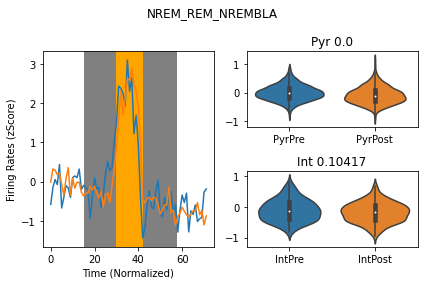

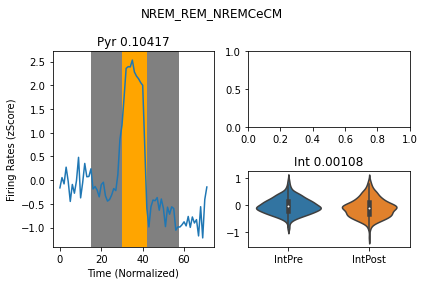

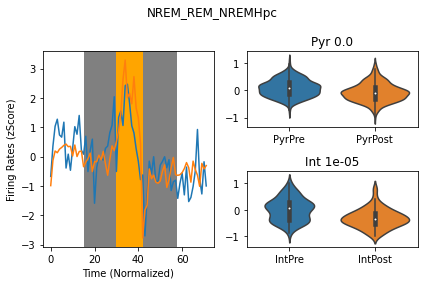

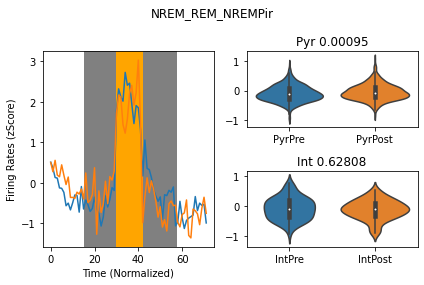

In [39]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_NREM_REM_NREM]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,15:30],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:42+15],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(15,30,color = 'grey')
                ax['A'].axvspan(30,30+12,color = 'orange')
                ax['A'].axvspan(42,42+15,color = 'grey')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)

                plt.suptitle(trans['name']+s)
            print(p)
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

## NREM Control

BLAPyr
(1735,)
1.5260359414928126e-25


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


BLAInt
(257,)
4.061079281639934e-21
0.0
CeCMInt
(707,)
3.455011784364892e-05
HpcPyr
(932,)
8.82534155634023e-41


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcInt
(130,)
7.020371306169866e-13
PirPyr
(944,)
2.463549029574644e-35
PirInt
(99,)
1.0088285959367005e-09


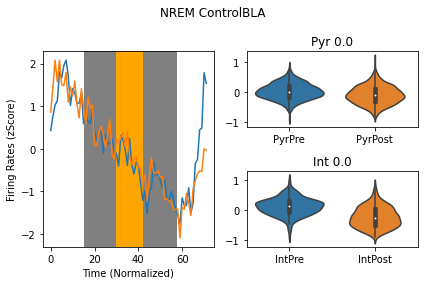

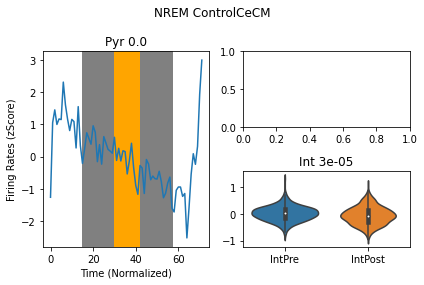

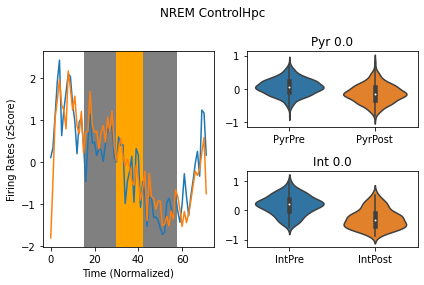

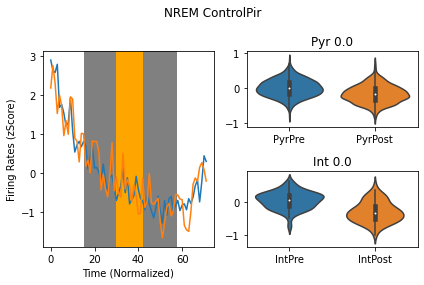

In [40]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_NREM_Control]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,15:30],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:42+15],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(15,30,color = 'grey')
                ax['A'].axvspan(30,30+12,color = 'orange')
                ax['A'].axvspan(42,42+15,color = 'grey')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)

                plt.suptitle(trans['name']+s)
            print(p)
            plt.title(f'{t}')
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

## REM_NREM_REM 

BLAPyr
(844,)
0.2691267645573422
BLAInt
(132,)
0.31106538490983604
0.31107
CeCMInt
(379,)
0.10297330693746189


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcPyr
(380,)
0.05860289063156927
HpcInt
(55,)
0.5026768557083605
PirPyr
(472,)
0.4402966921238851
PirInt
(60,)
0.49823626254144004


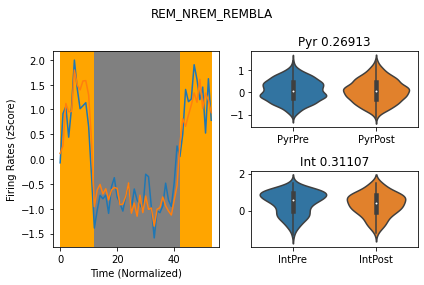

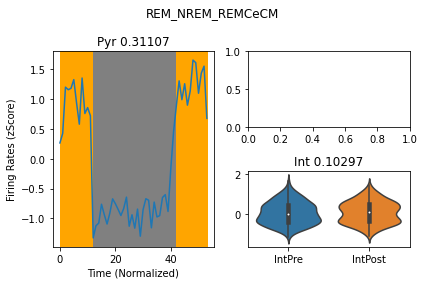

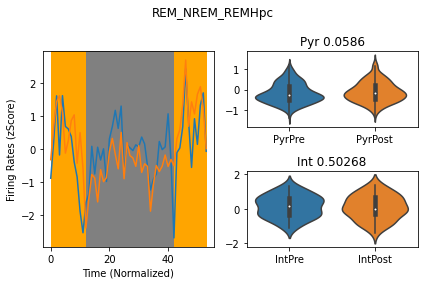

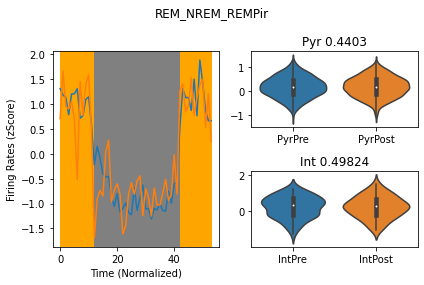

In [41]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_REM_NREM_REM]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,0:12],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(0,12,color = 'orange')
                ax['A'].axvspan(12,12+30,color = 'grey')
                ax['A'].axvspan(42,42+11,color = 'orange')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)
                plt.suptitle(trans['name']+s)
            
            print(p)
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

In [38]:
for r,i in enumerate(['Hpc','CeCM','BLA','Pir']):
    plt.figure()
    for t,j in enumerate(['Pyr','Int'],1):
        stru_type_activity = transitions_activity[(metadata.Region == i) & (metadata.Type == j)]
        plt.subplot(1,2,t)
        if np.any(stru_type_activity):
#             order = np.argsort(np.mean(stru_type_activity[:,30:41],1)/np.mean(stru_type_activity,1))
            plt.title(f'Stru : {i} type : {j}')
            plt.imshow(stru_type_activity[:,:],aspect='auto');
            plt.clim([-5,5])
    plt.tight_layout()

NameError: name 'transitions_activity' is not defined

<Figure size 432x288 with 0 Axes>

In [4]:
# transition_interest = [('Rem','sws'),('sws','Rem'),('Rem','wake')]
# s = "ABC"
# fig,ax = plt.subplot_mosaic('ABC')
# for ii,i in enumerate(transition_interest):
#     binned = []
#     for event,trans_time in zip(transitions[i].as_units('s').iloc,times[i].as_units('s').index.values):
#         print(trans_time)
#         print('he')
#         start = event.start
#         end = event.end
        
#         if (end-trans_time)<50 or (trans_time-start) <50: continue
# #         if (end-trans_time) > 180: end = trans_time+120
# #         if (trans_time-start) > 180: start = trans_time-120
        
        
        
#         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
#         t_post,b_post = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
#         b_pre = b_pre/((trans_time-start)/30)
#         b_post = b_post/((end-trans_time)/12)
#         t = np.hstack((t_pre,t_post))
#         b = np.hstack((b_pre,b_post))
        
# #         plt.figure()
# #         plt.plot(t,b.T)
# #         plt.axvline(trans_time,color = 'red')
#         binned.append(b)
#     ax[s[ii]].plot(np.mean(binned,0).T)
    
# plt.suptitle('Transition')

# NREM_REM Not Normalized

In [12]:
def plot_average_transition(average_transition,metadata,region,types,style,interval):
    X = scipy.stats.zscore(average_transition[(metadata.Region == region) & (metadata.Type == types)],1,nan_policy='omit').T
    y = np.nanmean(X,1)
    y_std = scipy.stats.sem(X,1,nan_policy='omit')
#     y_std = np.nanstd(X,1)
    t = np.linspace(-90,30,len(y))
    plt.plot(t,y,style)
    plt.plot(t,y+y_std,f'{style}--')
    plt.plot(t,y-y_std,f'{style}--')
    plt.axvspan(interval[0],interval[1],color = 'orange',alpha = 0.5)

In [29]:
def plot_average_spec(t_spec,f_spec,average_spec):
    average_spec = np.log(average_spec)
    plt.pcolormesh(t_spec-90,f_spec,average_spec,shading= 'gouraud',rasterized=True)
#     plt.imshow(average_spec,aspect='auto',origin='lower')
    plt.ylim(0,20)
    plt.clim(7,12)
    plt.ylabel('Freq (Hz)')
    plt.xlabel('Time (s)')

In [14]:
NREM_REM_NN = bk.load.batch(main_non_normalized,arg = None,linux = True,verbose = False)

100%|██████████| 61/61 [04:32<00:00,  4.46s/it]

Batch finished in 272.3136067390442
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


In [15]:
m_NREM_REM_NN = merge_with_spec(NREM_REM_NN,'NREM_REM_NN',discard)

# Figure NN NREM_REM

<ipython-input-33-793408e47117>:28: RuntimeWarning: invalid value encountered in true_divide
  order = np.argsort(np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,89:],1)/np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,0:89],1))


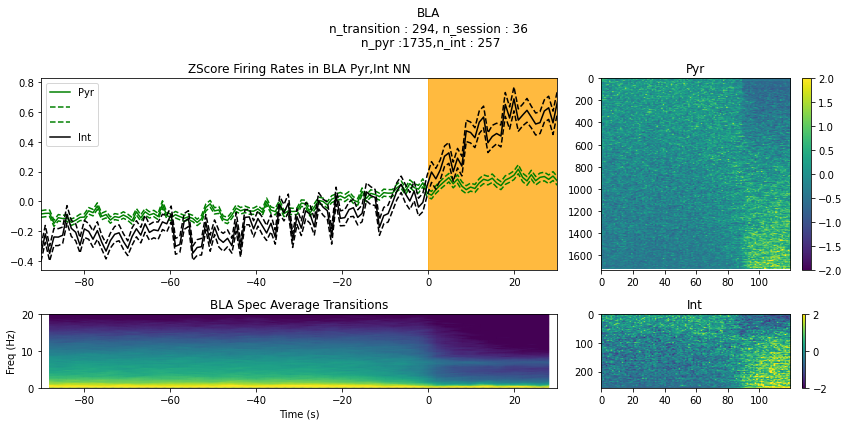

In [33]:
BLA_PYR_Filt = (m_NREM_REM_NN['metadata'].Region == 'BLA') & (m_NREM_REM_NN['metadata'].Type == 'Pyr')
BLA_INT_Filt = (m_NREM_REM_NN['metadata'].Region == 'BLA') & (m_NREM_REM_NN['metadata'].Type == 'Int')

n_transition = m_NREM_REM_NN['n_transitions']
n_sessions = m_NREM_REM_NN['n_sessions']
n_pyr = np.sum(BLA_PYR_Filt)
n_int = np.sum(BLA_INT_Filt)

fig,ax = plt.subplot_mosaic('''AAC
                               AAC
                               BBD
                    ''',
                   figsize=[12,6])
plt.sca(ax['A'])
plot_average_transition(m_NREM_REM_NN['average_transition'],m_NREM_REM_NN['metadata'],'BLA','Pyr','g',[0,30])
plot_average_transition(m_NREM_REM_NN['average_transition'],m_NREM_REM_NN['metadata'],'BLA','Int','k',[0,30])
plt.legend(['Pyr','','','Int'])
plt.title(f'ZScore Firing Rates in BLA Pyr,Int NN')


plt.sca(ax['B'])
plot_average_spec(m_NREM_REM_NN['t_spec'],m_NREM_REM_NN['f_spec'],np.mean(m_NREM_REM_NN['average_spec'],0))
plt.title('BLA Spec Average Transitions')
plt.xlim(-90,30)
ax['A'].sharex(ax['B'])

plt.sca(ax['C'])
order = np.argsort(np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,89:],1)/np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,0:89],1))
plt.imshow(scipy.stats.zscore(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][order],1,nan_policy='omit'),aspect='auto')
plt.clim(-2,2)
plt.title('Pyr')
plt.colorbar()


plt.sca(ax['D'])
order = np.argsort(np.nanmean(m_NREM_REM_NN['average_transition'][BLA_INT_Filt][:,89:],1)/np.nanmean(m_NREM_REM_NN['average_transition'][BLA_INT_Filt][:,0:89],1))
plt.imshow(scipy.stats.zscore(m_NREM_REM_NN['average_transition'][BLA_INT_Filt][order],1,nan_policy='omit'),aspect='auto')
plt.clim(-2,2)
plt.title('Int')
plt.colorbar()





plt.suptitle(f'BLA\nn_transition : {n_transition}, n_session : {n_sessions}\n n_pyr :{n_pyr},n_int : {n_int}')
plt.tight_layout()
plt.savefig('/mnt/work/Figures_Gabrielle/NREM_REM_NN.svg')

In [217]:
m_NREM_REM_NN['average_transition'][BLA_INT_Filt]

array([], shape=(0, 120), dtype=float64)

In [64]:
def shank_to_structure(rat,day,shank):
    structures_path = os.path.join(bk.load.base,'All-Rats/Structures/structures.mat')
    structures = scipy.io.loadmat(structures_path)
    useless  = ['__header__','__version__','__globals__','basal','olfact']
    for u in useless:
        del structures[u]
        
    for stru,array in structures.items(): 
        filtered_array = array[np.all(array == [rat,day,shank],1)]
        if np.any(filtered_array):
            print(stru,filtered_array)
            return stru
        
def channels(session):   
    tree = ET.parse(session+'.xml')
    root = tree.getroot()
    shank_channels = {}
    
    i = 0
    for anatomicalDescription in root.iter('anatomicalDescription'): 
        for channelGroups in anatomicalDescription.iter('channelGroups'):
            for group in channelGroups.iter('group'):
                i += 1
                channels = []
                for channel in group.iter('channel'):
                    channels.append(int(channel.text))
                stru = shank_to_structure(rat,day,shank)
                shank_channels.update({i:[channels,stru]})
    return shank_channels